In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

## Data loading:

In [6]:
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

Hàm load_mnist trên được sử dụng để tải dữ liệu từ tập dữ liệu MNIST

In [7]:
X_train, y_train = load_mnist('Contents', kind='train')
X_test, y_test = load_mnist('Contents', kind='t10k')

## Data Preprocessing:

In [8]:
# In ra shape của dữ liệu
print('Training Data Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Data Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

# In ra một số thông tin về dữ liệu
print('\nThông tin dữ liệu:')
print('Giá trị pixel trong khoảng:', X_train.min(), 'đến', X_train.max())
print('Số lượng classes:', len(np.unique(y_train)))

Training Data Shape: (60000, 784)
Training Labels Shape: (60000,)
Testing Data Shape: (10000, 784)
Testing Labels Shape: (10000,)

Thông tin dữ liệu:
Giá trị pixel trong khoảng: 0 đến 255
Số lượng classes: 10


In [9]:
# Classes of Fashion MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [10]:
# Set random seed for reproducibility
np.random.seed(0)

# Get one image from training set and reshape to 28x28
img = X_train[0].reshape(28, 28)

# Print the pixel matrix
print("Pixel matrix of the image (28x28 size):")
print("Each number represents pixel intensity (0-255):")
print()

for i in range(28):
    for j in range(28):
        print(f"{int(img[i,j]):3d}", end=" ")
    print()  

Pixel matrix of the image (28x28 size):
Each number represents pixel intensity (0-255):

  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0   0   1   4   0   0   0   0   1   1   0 
  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62  54   0   0   0   1   3   4   0   0   3 
  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134 144 123  23   0   0   0   0  12  10   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178 107 156 161 109  64  23  77 130  72  15 
  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216 216 163 127 121 122 146 141  88 172  66 
  0   0

Hiển thị một hình ảnh từ tập huấn luyện MNIST dưới dạng ma trận pixel.

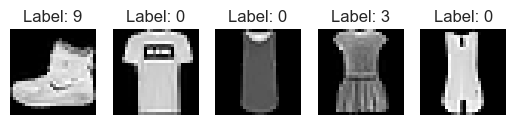

In [11]:
# Hiển thị 5 hình ảnh đầu tiên trong tập huấn luyện
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_train[i].reshape(28, 28), cmap="gray")  
    plt.title(f"Label: {y_train[i]}")
    plt.axis("off")

plt.show()

In [12]:
def find_duplicates(X):
    unique_images, indices = np.unique(X, axis=0, return_index=True)
    return len(X) != len(unique_images), indices

has_duplicates, unique_indices = find_duplicates(X_train)
if has_duplicates:
    print("Dataset has duplicates.")
else:
    print("No duplicates found.")

df = pd.DataFrame(X_train)

print("Missing values in DataFrame:", df.isnull().sum().sum())

No duplicates found.
Missing values in DataFrame: 0


In [13]:
X_train = X_train / 255.0
X_test = X_test / 255.0

Xmean = X_train.mean(axis=0)
X_train = X_train - Xmean
X_test = X_test - Xmean

Thực hiện quá trình chuẩn hóa dữ liệu hình ảnh trong tập huấn luyện và tập kiểm tra MNIST, nhằm cải thiện hiệu suất của mô hình học máy
- chia tất cả các giá trị pixel của hình ảnh trong tập huấn luyện X_train và tập kiểm tra X_test cho 255. Giá trị pixel, ban đầu nằm trong khoảng từ 0 đến 255, sẽ được chuyển đổi về khoảng từ 0 đến 1, chuẩn hóa giá trị pixel giúp cải thiện tốc độ hội tụ và hiệu suất của các thuật toán học máy, vì nó làm cho các giá trị đầu vào đồng nhất và giảm thiểu sự ảnh hưởng của các giá trị lớn hơn.
- Sử dụng phương pháp mean centering làm cho dữ liệu được phân bố xung quanh giá trị 0, giúp mô hình học máy dễ dàng hơn trong việc học và tối ưu hóa các trọng số

In [14]:
print("First image in training set:\n", np.array(X_train[0]).reshape(28, 28)) 
print("Label:", y_train[0])

First image in training set:
 [[-3.13725490e-06 -2.26797386e-05 -1.17973856e-04 -4.07058824e-04
  -9.79150327e-04 -1.62633987e-03 -3.22222222e-03 -8.72444444e-03
  -2.23477124e-02 -5.66064706e-02 -1.29239020e-01 -1.80072810e-01
  -2.04284706e-01 -1.99492484e-01 -1.98128889e-01 -2.11397712e-01
  -2.02067778e-01 -1.59424575e-01 -1.02428889e-01 -4.08181046e-02
  -1.61122876e-02 -7.76346405e-03 -4.63261438e-03 -3.33450980e-03
  -1.87000000e-03 -1.02065359e-03 -3.82941176e-04 -6.59477124e-05]
 [-2.79084967e-05 -9.43137255e-05 -3.95620915e-04 -1.42718954e-03
  -3.01934641e-03 -8.17150327e-03 -2.88511111e-02 -6.87690196e-02
  -1.25668431e-01 -2.07564510e-01 -3.12554444e-01 -3.92771046e-01
  -4.43457320e-01 -4.36227843e-01 -4.27772288e-01 -4.49786013e-01
  -4.33664379e-01 -3.57459673e-01 -2.81273007e-01 -1.76994379e-01
  -1.02619150e-01 -5.34571242e-02 -2.42860784e-02 -1.36563399e-02
  -8.66692810e-03 -4.73875817e-03 -1.83477124e-03 -3.27254902e-04]
 [-1.02483660e-04 -3.18235294e-04 -1.0451634

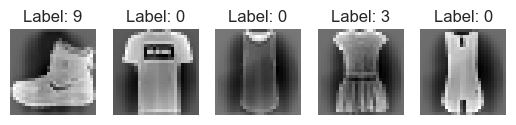

In [15]:
# Hiển thị 5 hình ảnh đầu tiên trong tập huấn luyện sau khi được chuẩn hóa
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_train[i].reshape(28, 28), cmap="gray")  
    plt.title(f"Label: {y_train[i]}")
    plt.axis("off")

plt.show()

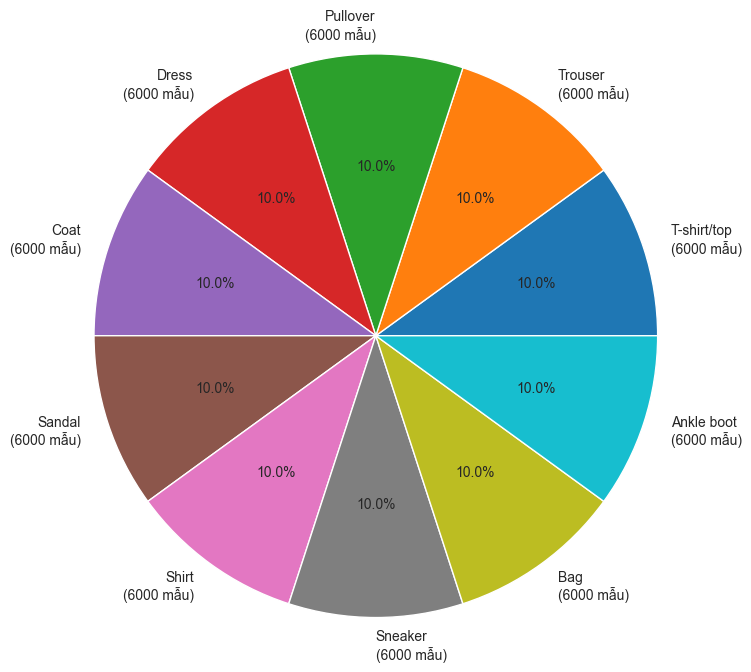

In [16]:
from collections import Counter

class_counts = Counter(y_train)

class_dict = {i: name for i, name in enumerate(class_names)}

plt.figure(figsize=(8, 8))
plt.pie([class_counts[i] for i in range(10)], 
        labels=[f"{class_dict[i]}\n({class_counts[i]} mẫu)" for i in range(10)],
        autopct='%1.1f%%')
plt.title('')
plt.axis('equal')
plt.show()

Ta thấy được về các class trong tập test của bộ dữ liệu
- Phân phối đồng đều: Mỗi class trong tập test đều có số lượng mẫu giống nhau, cụ thể là 6000 mẫu. Điều này tương ứng với tỉ lệ 10% cho mỗi loại sản phẩm
- Cân bằng dữ liệu: Tập dữ liệu test được phân phối đồng đều cho từng class, điều này giúp tránh hiện tượng lệch lớp (class imbalance). Một tập dữ liệu cân bằng hỗ trợ mô hình học máy trong việc nhận diện từng loại sản phẩm một cách công bằng và giảm nguy cơ thiên vị.

## Support Vector Machine (SVM):

Support Vector Machine (SVM) là một thuật toán học có giám sát, được sử dụng để phân loại và hồi quy. Trong phân loại, SVM hoạt động bằng cách tìm kiếm một siêu phẳng (hyperplane) tối ưu để phân chia dữ liệu thành các lớp khác nhau. Mục tiêu của SVM là tối đa hóa khoảng cách giữa các điểm dữ liệu gần nhất của hai lớp và siêu phẳng phân chia chúng. Khoảng cách này được gọi là lề (margin), và một siêu phẳng với lề lớn hơn thường có khả năng tổng quát hóa tốt hơn khi phân loại các điểm dữ liệu mới.
1. Nguyên lý hoạt động của SVM
   - **Tìm Siêu phẳng Tối ưu:** SVM tìm kiếm siêu phẳng tối ưu để phân chia các lớp bằng cách tối đa hóa lề giữa các điểm dữ liệu gần nhất của hai lớp (các điểm này được gọi là các vector hỗ trợ (support vectors)). Đối với bài toán tuyến tính, siêu phẳng này có thể được biểu diễn bởi phương trình: $w \cdot x + b = 0$. $w$ là vector trọng số, hay vector pháp tuyến (normal vector) của siêu phẳng tối ưu, $x$ là vector đại diện cho các điểm dữ liệu, $b$ là bias, hay độ dịch của siêu phẳng tối ưu.
   - **Tối ưu hóa Lề:** SVM tối ưu hóa lề bằng cách tìm các vector hỗ trợ và thiết lập khoảng cách giữa chúng và siêu phẳng tối ưu. Lề lớn hơn giúp giảm nguy cơ overfitting, cải thiện khả năng dự đoán trên dữ liệu mới.

2. SVM với Nhân (Kernel)
- Với các dữ liệu phức tạp hoặc không thể phân tách tuyến tính, SVM sử dụng hàm kernel để biến đổi dữ liệu thành không gian đặc trưng cao hơn, nơi các lớp có thể phân tách dễ dàng hơn. Một số hàm kernel phổ biến bao gồm:
   - **Linear Kernel:** Phù hợp cho dữ liệu có thể phân tách tuyến tính.
   - **Polynomial Kernel:** Biến đổi dữ liệu với hàm đa thức.
   - **Radial Basis Function (RBF) Kernel:** Là hàm kernel phổ biến nhất cho dữ liệu không tuyến tính, biến đổi dữ liệu vào một không gian vô hạn chiều, giúp phân tách các điểm dữ liệu phức tạp.

### Implement SVM

In [17]:
# Hàm để train và evaluate model
def train_and_evaluate_svm(X_train, X_test, y_train, y_test, kernel='linear', C=1.0):
    # Ghi lại thời gian bắt đầu
    start_time = time.time()
    
    # Khởi tạo model
    svm = SVC(kernel=kernel, C=C)
    
    # Train model
    print(f"\nTraining SVM with {kernel} kernel...")
    svm.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # Thời gian prediction
    start_time = time.time()
    y_pred = svm.predict(X_test)
    predict_time = time.time() - start_time
    
    # Tính accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # In kết quả
    print(f"\nKết quả cho SVM với {kernel} kernel:")
    print(f"Thời gian training: {train_time:.2f} giây")
    print(f"Thời gian prediction: {predict_time:.2f} giây")
    print(f"Accuracy: {accuracy:.4f}")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, 
                              target_names=class_names))
    
    return svm, y_pred, train_time, predict_time, accuracy

def train_and_evaluate_svm_v2(X_train, X_test, y_train, y_test, kernel='linear', C=1.0):
    # Ghi lại thời gian bắt đầu
    start_time = time.time()
    
    # Khởi tạo model
    svm = SVC(kernel=kernel, C=C)
    
    # Train model
    print(f"\nTraining SVM with {kernel} kernel and small sample...")
    svm.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # Thời gian prediction
    start_time = time.time()
    y_pred = svm.predict(X_test)
    predict_time = time.time() - start_time
    
    # Tính accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # In kết quả
    print(f"\nKết quả cho SVM với {kernel} kernel:")
    print(f"Thời gian training: {train_time:.2f} giây")
    print(f"Thời gian prediction: {predict_time:.2f} giây")
    print(f"Accuracy: {accuracy:.4f}")
    
    return svm, y_pred, train_time, predict_time, accuracy

# Visualize confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


Training SVM with linear kernel...

Kết quả cho SVM với linear kernel:
Thời gian training: 288.81 giây
Thời gian prediction: 59.51 giây
Accuracy: 0.8464

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.75      0.81      0.78      1000
     Trouser       0.97      0.96      0.97      1000
    Pullover       0.73      0.77      0.75      1000
       Dress       0.85      0.84      0.85      1000
        Coat       0.76      0.77      0.77      1000
      Sandal       0.93      0.94      0.93      1000
       Shirt       0.63      0.56      0.60      1000
     Sneaker       0.92      0.93      0.93      1000
         Bag       0.95      0.93      0.94      1000
  Ankle boot       0.95      0.94      0.95      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



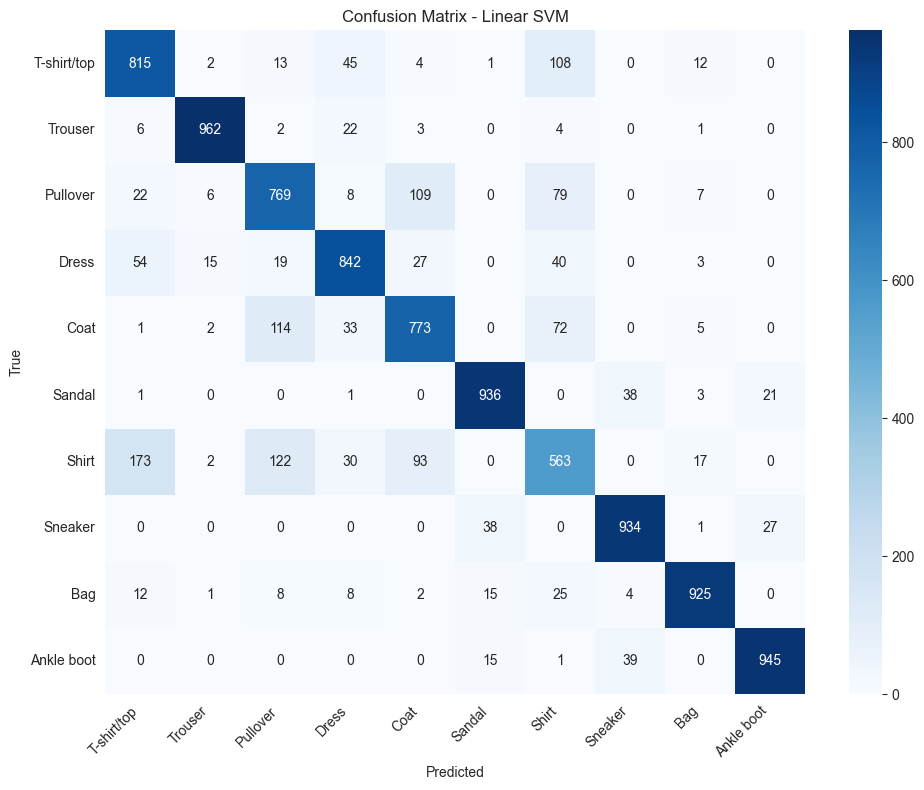

In [18]:
# Train và evaluate Linear SVM
linear_svm, linear_pred, linear_train_time, linear_pred_time, linear_acc = \
    train_and_evaluate_svm(X_train, X_test, y_train, y_test, kernel='linear')
# Plot confusion matrices
plot_confusion_matrix(y_test, linear_pred, 'Confusion Matrix - Linear SVM')

Thời gian huấn luyện và dự đoán:

- Thời gian huấn luyện: 340.94 giây, cho thấy mô hình mất khá nhiều thời gian để huấn luyện. Điều này do kích thước dữ liệu lớn hoặc số chiều dữ liệu cao.
- Thời gian dự đoán: 76.61 giây, là hợp lý nhưng vẫn cho thấy việc dự đoán mất thời gian đáng kể.
- 
Độ chính xác (Accuracy):
Độ chính xác tổng thể của mô hình là 84.64%, đây là một kết quả tốt đối với SVM tuyến tính

Các chỉ số phân loại:
- Các lớp Trouser và Ankle boot có kết quả cao nhất, với precision, recall và f1-score gần hoặc trên 90%. Điều này cho thấy mô hình rất chính xác với các lớp này.
- Shirt và Bag có điểm số thấp hơn, đặc biệt là về độ chính xác (precision) và f1-score, điều này cho thấy mô hình gặp khó khăn hơn khi phân loại các danh mục này. Nguyên nhân có thể là do chúng có đặc điểm dễ nhầm lẫn với các danh mục khác.
- Macro average (trung bình không trọng số của các chỉ số trên tất cả các lớp) và Weighted average (trung bình có trọng số theo số lượng mẫu của mỗi lớp) đều cho thấy f1-score ở mức 85%.

Hiệu suất cân bằng:
- Với f1-score trung bình (macro và weighted) khoảng 0.85, mô hình có vẻ hoạt động cân bằng trên các lớp, nhưng điểm số thấp ở một số lớp như Shirt và Bag cho thấy có thể có sự nhầm lẫn giữa chúng và các mặt hàng tương tự.

Từ confusion matrix có thể thấy được mô hình gặp khó khăn khi phân loại shirt và T-shirt/top vì chúng khá là giống nhau, điều này cũng xảy ra tương tự với Pullover - Shirt, Coat - Shirt và Coat - Pullover


Training SVM with rbf kernel...

Kết quả cho SVM với rbf kernel:
Thời gian training: 256.95 giây
Thời gian prediction: 103.76 giây
Accuracy: 0.8879

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.83      0.86      0.85      1000
     Trouser       0.99      0.96      0.98      1000
    Pullover       0.80      0.82      0.81      1000
       Dress       0.87      0.89      0.88      1000
        Coat       0.81      0.82      0.82      1000
      Sandal       0.97      0.96      0.96      1000
       Shirt       0.73      0.67      0.70      1000
     Sneaker       0.93      0.96      0.95      1000
         Bag       0.97      0.98      0.98      1000
  Ankle boot       0.97      0.95      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



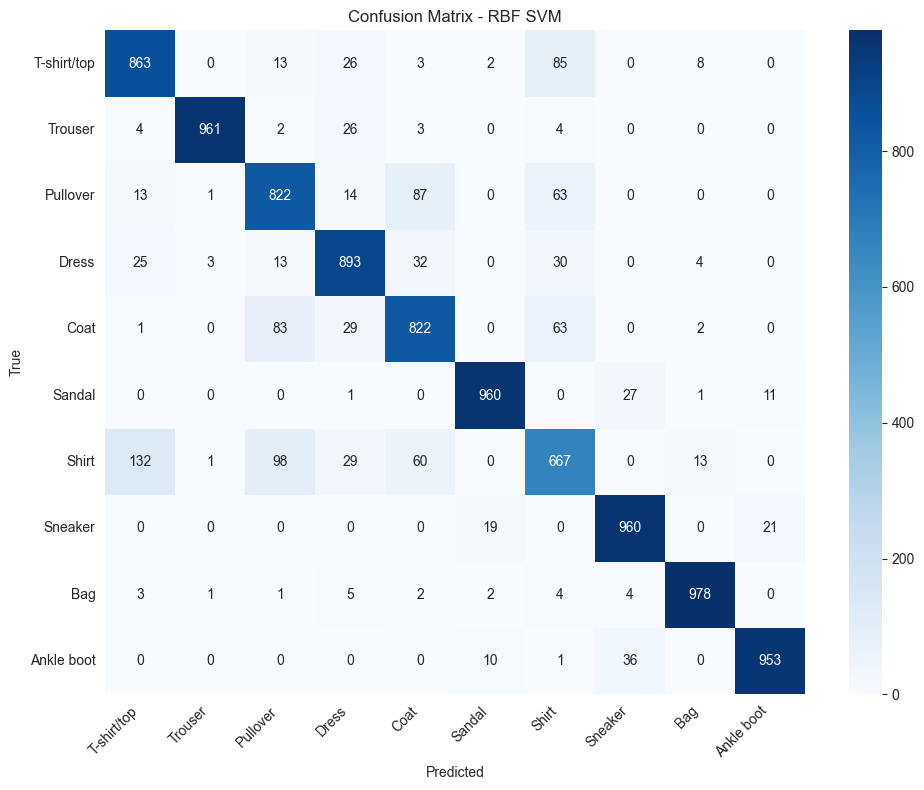

In [19]:
# Train và evaluate RBF SVM
rbf_svm, rbf_pred, rbf_train_time, rbf_pred_time, rbf_acc = \
    train_and_evaluate_svm(X_train, X_test, y_train, y_test, kernel='rbf')
plot_confusion_matrix(y_test, rbf_pred, 'Confusion Matrix - RBF SVM')

Thời gian huấn luyện và dự đoán:
- Thời gian huấn luyện: 283.57 giây, ngắn hơn so với mô hình SVM với kernel tuyến tính (340.94 giây), cho thấy kernel RBF tối ưu hơn một chút về thời gian huấn luyện.
- Thời gian dự đoán: 207.57 giây, dài hơn đáng kể so với kernel tuyến tính (76.61 giây)
    
Độ chính xác (Accuracy):
- Độ chính xác của mô hình là 88.79%, cao hơn đáng kể so với kernel tuyến tính (84.64%)
- Precision, Recall, và F1-score đều tăng so với mô hình tuyến tính
- Các lớp như Trouser, Sneaker, và Ankle boot vẫn giữ được kết quả rất cao, với f1-score xấp xỉ hoặc trên 0.95, cho thấy mô hình nhận diện rất tốt cho các lớp này.
- Lớp Shirt vẫn là lớp có kết quả thấp nhất, với f1-score là 0.76 (cao hơn một chút so với kernel tuyến tính). Điều này cho thấy dù đã có cải thiện, nhưng Shirt vẫn dễ bị nhầm lẫn với các lớp khác.

Hiệu suất tổng thể:
- Macro avg và Weighted avg của f1-score đều đạt 0.89, cao hơn so với kernel tuyến tính (0.85). Điều này cho thấy kernel RBF giúp cải thiện hiệu suất tổng thể trên tất cả các lớp.

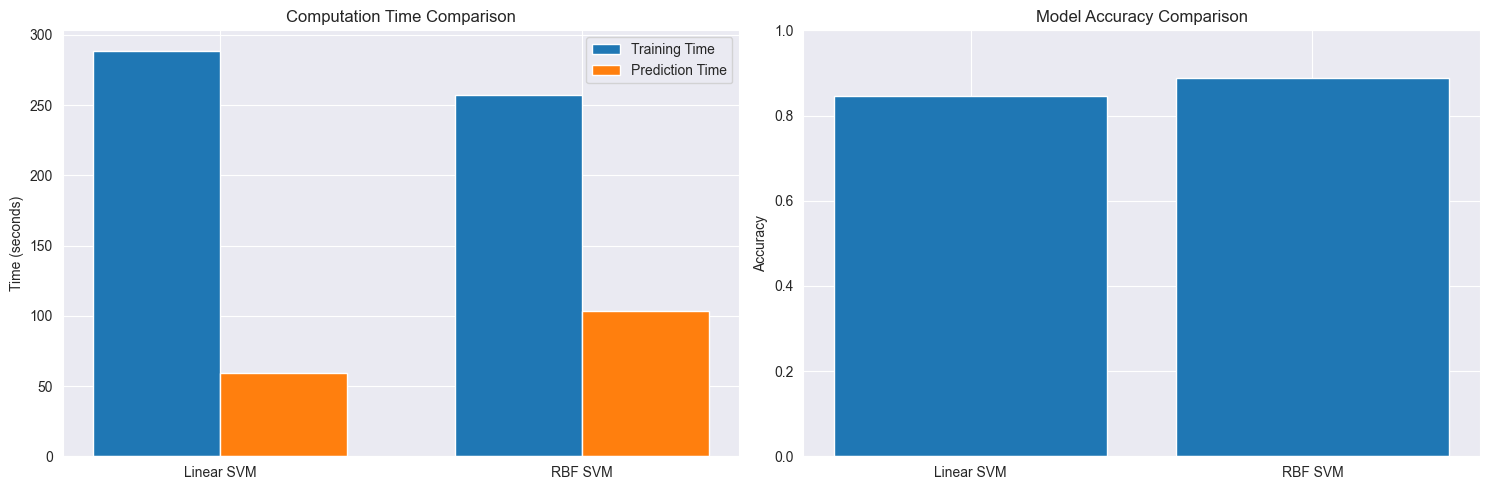


Kết quả tổng hợp:
     Model  Training Time (s)  Prediction Time (s)  Accuracy
Linear SVM         288.805214            59.510849    0.8464
   RBF SVM         256.946382           103.761336    0.8879


In [20]:
# So sánh thời gian và accuracy
models = ['Linear SVM', 'RBF SVM']
train_times = [linear_train_time, rbf_train_time]
pred_times = [linear_pred_time, rbf_pred_time]
accuracies = [linear_acc, rbf_acc]

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Time comparison
x = range(len(models))
width = 0.35

ax1.bar(x, train_times, width, label='Training Time')
ax1.bar([i + width for i in x], pred_times, width, label='Prediction Time')
ax1.set_ylabel('Time (seconds)')
ax1.set_title('Computation Time Comparison')
ax1.set_xticks([i + width/2 for i in x])
ax1.set_xticklabels(models)
ax1.legend()

# Accuracy comparison
ax2.bar(models, accuracies)
ax2.set_ylabel('Accuracy')
ax2.set_title('Model Accuracy Comparison')
ax2.set_ylim([0, 1])

plt.tight_layout()
plt.show()

# In kết quả tổng hợp
print("\nKết quả tổng hợp:")
results_df = pd.DataFrame({
    'Model': models,
    'Training Time (s)': train_times,
    'Prediction Time (s)': pred_times,
    'Accuracy': accuracies
})
print(results_df.to_string(index=False))

- Thời gian huấn luyện (Training Time):
Linear SVM có thời gian huấn luyện dài hơn so với RBF SVM. Điều này có thể do RBF SVM thường hiệu quả hơn trong việc tìm kiếm siêu phẳng phân chia tối ưu trong không gian phi tuyến tính, nhờ khả năng tạo ra các không gian đặc trưng cao hơn.
- Thời gian dự đoán (Prediction Time):
RBF SVM có thời gian dự đoán dài hơn Linear SVM. Điều này có thể do tính toán trong không gian đặc trưng cao hơn, khiến việc dự đoán của RBF phức tạp hơn.
- Độ chính xác
Độ chính xác của RBF SVM cao hơn một chút so với Linear SVM. RBF có khả năng xử lý tốt hơn với dữ liệu không tuyến tính nhờ khả năng biến đổi không gian đầu vào sang không gian đặc trưng cao hơn, giúp phân loại chính xác hơn các mẫu phức tạp.
- Lý do chênh lệch
    - Bản chất dữ liệu:Nếu dữ liệu có quan hệ tuyến tính, Linear SVM có thể hoạt động tốt. Tuy nhiên, bộ dữ liệu Fashion-MNIST là dữ liệu có cấu trúc phi tuyến tính, RBF SVM sẽ có ưu thế nhờ khả năng biến đổi không gian.
    - Tính linh hoạt: RBF kernel có khả năng linh hoạt hơn trong việc điều chỉnh để phù hợp với sự phức tạp của dữ liệu, trong khi Linear SVM chỉ có thể tạo ra một siêu phẳng tuyến tính.
    - Chi phí tính toán: Linear SVM thường nhanh hơn trong dự đoán do tính toán ít phức tạp hơn, nhưng có thể chậm hơn trong huấn luyện nếu cần tìm kiếm siêu phẳng tối ưu cho dữ liệu lớn.

### Hyperparameter tuning

SVM có hai tham số quan trọng:
- C (Cost): Tham số này kiểm soát độ cứng/mềm của lề. Khi 𝐶 lớn, SVM sẽ cố gắng phân loại chính xác tất cả các điểm dữ liệu, kể cả khi phải hy sinh khoảng cách lề, dẫn đến nguy cơ overfitting. Khi 𝐶 nhỏ, SVM sẽ cho phép một số điểm nằm sai phía của siêu phẳng, tăng cường khả năng tổng quát hóa.
- Gamma (đối với RBF Kernel): Tham số gamma xác định phạm vi ảnh hưởng của một điểm dữ liệu đơn lẻ. Giá trị gamma cao khiến mỗi điểm dữ liệu chỉ ảnh hưởng đến những điểm gần nó, giúp tạo ra biên giới phân lớp phức tạp hơn. Ngược lại, gamma thấp sẽ khiến mỗi điểm ảnh hưởng đến toàn bộ dữ liệu, tạo ra biên giới đơn giản hơn.

Trong phần này chỉ đi hiệu chinh tham số C để đạt được độ chính xác cao nhất cho RBF SVM vì nó phù hợp với bộ dữ liệu Fashion-MNIST

Vì sự hiệu chỉnh cần chạy mô hình nhiều lần nên sẽ thực hiện chia nhỏ mẫu ra để chạy với mục đích nhằm rút ngắn thời gian huấn luyện.

In [21]:
def balance_classes(X, y, num_classes=10, samples_per_class=600):
    X_balanced, y_balanced = [], []
    
    for i in range(num_classes):
        class_indices = np.where(y == i)[0]
        chosen_indices = np.random.choice(class_indices, samples_per_class, replace=False)
        
        X_balanced.append(X[chosen_indices])
        y_balanced.append(y[chosen_indices])
    
    return np.vstack(X_balanced), np.hstack(y_balanced)

# Balance train and test data
X_small_train, y_small_train = balance_classes(X_train, y_train, num_classes=10, samples_per_class=600)
X_small_test, y_small_test = balance_classes(X_test, y_test, num_classes=10, samples_per_class=100)


Đảm bảo dữ liệu có nhãn balance khi lấy sample, hướng tiếp cận này là two-stage training, mẫu dữ liệu nhỏ bằng 1/10 mẫu dữ liệu gốc

In [22]:
# Train và evaluate RBF SVM trên bộ mẫu nhỏ 
rbf_svm, rbf_pred_s, rbf_train_time_s, rbf_pred_time_s, rbf_acc_s = \
    train_and_evaluate_svm_v2(X_small_train, X_small_test, y_small_train, y_small_test, kernel='rbf')


Training SVM with rbf kernel and small sample...

Kết quả cho SVM với rbf kernel:
Thời gian training: 4.19 giây
Thời gian prediction: 1.78 giây
Accuracy: 0.8380


Mẫu dữ liệu nhỏ bằng 1/10 so với ban đầu cho ra các thông số cao của mô hình RBF SVM, với thời gian huấn luyện và thời gian test giảm khoảng 100 lần so với dữ liệu gốc mà nó lại cho độ chính xác chỉ chênh lệch khoảng 4%. Thấy được dữ liệu gốc là bộ dữ liệu lý tưởng cho mô hình máy học 

In [23]:
import warnings
warnings.filterwarnings("ignore")

X_small_df = pd.DataFrame(X_small_train)
y_small_df = pd.DataFrame(y_small_train)

Cs = np.logspace(-2, 3, num=10)
MCV_list = []

for C in Cs:
    current_svm = SVC(kernel='rbf', C=C)
    kf = KFold(n_splits=3, random_state=1, shuffle=True)

    mean_crossval = np.mean(cross_val_score(current_svm, X_small_df, y_small_df, cv=kf))
    MCV_list.append(mean_crossval)
    print("On C=", C, "\tMCV=", mean_crossval)


On C= 0.01 	MCV= 0.588
On C= 0.03593813663804628 	MCV= 0.7334999999999999
On C= 0.1291549665014884 	MCV= 0.7821666666666666
On C= 0.464158883361278 	MCV= 0.8248333333333333
On C= 1.6681005372000592 	MCV= 0.8526666666666666
On C= 5.994842503189409 	MCV= 0.8603333333333335
On C= 21.544346900318846 	MCV= 0.8543333333333333
On C= 77.42636826811278 	MCV= 0.8553333333333333
On C= 278.2559402207126 	MCV= 0.8553333333333333
On C= 1000.0 	MCV= 0.8553333333333333


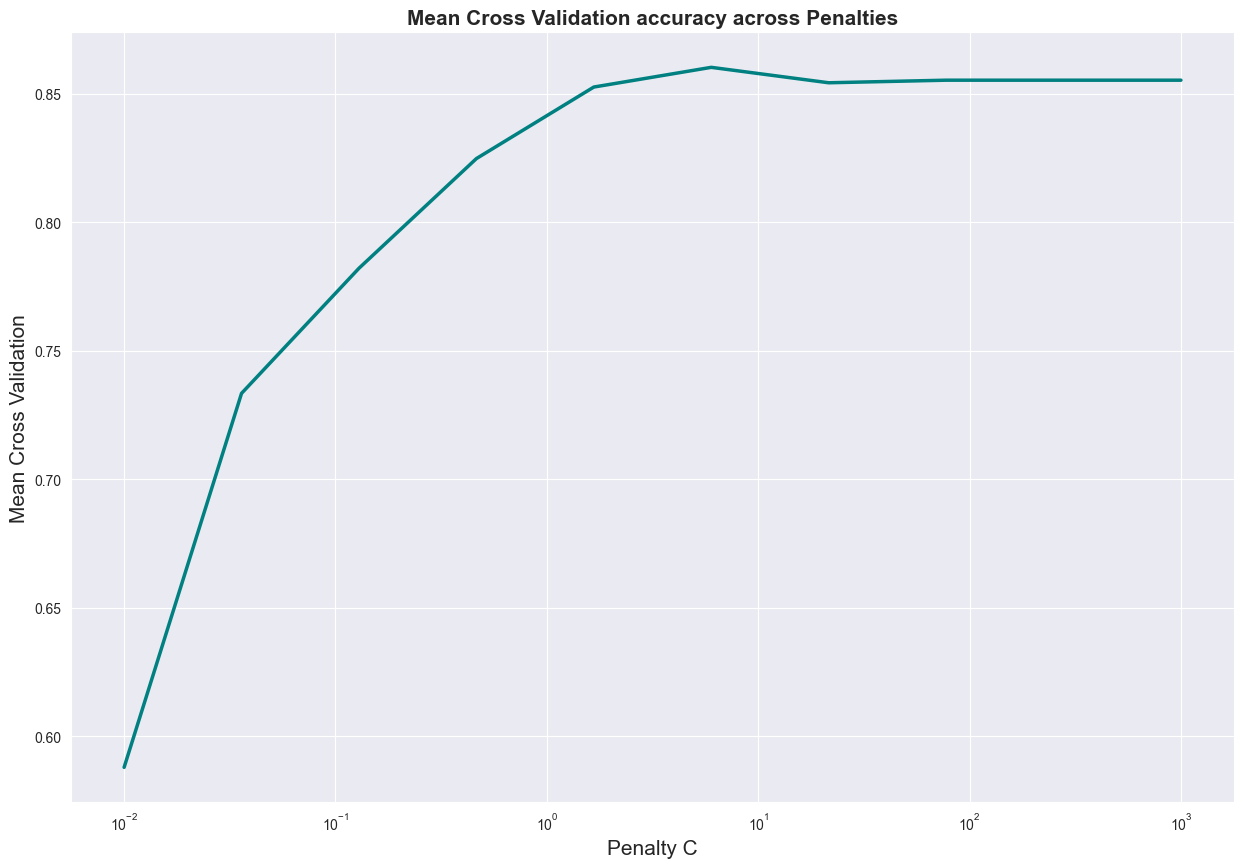

In [24]:
sns.set_style('darkgrid')
fig = plt.figure(figsize=(15,10))
lw = 2.5

plt.plot(Cs, MCV_list, color= 'teal', linewidth = lw)
plt.title("Mean Cross Validation accuracy across Penalties" ,fontsize=15, fontweight="bold")
plt.xlabel('Penalty C', fontsize = 15)
plt.xscale("log")
plt.ylabel('Mean Cross Validation', fontsize = 15)
plt.show()

Chọn 𝐶=5.994842503189409 vì nó đạt MCV cao nhất và không có dấu hiệu giảm hiệu suất đáng kể khi thử nghiệm trên các giá trị C cao hơn có thể an tâm rằng mô hình không bị overfitting.

In [25]:
# Train và evaluate RBF SVM
rbf_svm, rbf_pred, rbf_train_time, rbf_pred_time, rbf_acc = \
    train_and_evaluate_svm_v2(X_small_train, X_small_test, y_small_train, y_small_test, kernel='rbf', C=5.994842503189409)


Training SVM with rbf kernel and small sample...

Kết quả cho SVM với rbf kernel:
Thời gian training: 4.10 giây
Thời gian prediction: 1.52 giây
Accuracy: 0.8750


Mọi thông số sau khi huấn huyện mô hình bằng giá trị C mới thì có sự cải thiện lớn 

In [26]:
# Train và evaluate RBF SVM
rbf_svm, rbf_pred, rbf_train_time, rbf_pred_time, rbf_acc = \
    train_and_evaluate_svm(X_train, X_test, y_train, y_test, kernel='rbf', C=5.994842503189409)


Training SVM with rbf kernel...

Kết quả cho SVM với rbf kernel:
Thời gian training: 250.24 giây
Thời gian prediction: 100.89 giây
Accuracy: 0.9013

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.84      0.85      0.85      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.82      0.83      0.83      1000
       Dress       0.90      0.91      0.91      1000
        Coat       0.84      0.84      0.84      1000
      Sandal       0.97      0.98      0.97      1000
       Shirt       0.75      0.72      0.73      1000
     Sneaker       0.95      0.96      0.96      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.97      0.96      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



Việc điều chỉnh tham số C đã giúp mô hình đạt được hiệu suất cao với độ chính xác tổng thể 90.13%. Hơn nữa, thời gian huấn luyện và dự đoán thấp hơn so với mô hình ban đầu cho thấy mô hình này đã thực hiện tốt hơn.

## PCA và LDA

Phân tích Phân biệt Tuyến tính (LDA) và Phân tích Thành phần Chính (PCA) đều là các kỹ thuật giảm chiều dữ liệu phổ biến trong học máy, nhưng chúng khác nhau cơ bản về mục tiêu, cách hoạt động và cách chúng biến đổi dữ liệu. Dưới đây là sự khác biệt giữa chúng:
1. Mục tiêu
- PCA: Tìm kiếm các hướng (thành phần chính) để giải thích sự biến thiên lớn nhất trong dữ liệu, không phụ thuộc vào nhãn lớp. Đây là một kỹ thuật không giám sát, nghĩa là nó không xem xét các nhãn lớp khi xác định các hướng trong dữ liệu.
- LDA: Nhằm tối đa hóa sự tách biệt giữa các lớp bằng cách tìm ra các hướng làm tăng khoảng cách giữa các trung bình của các lớp khác nhau, đồng thời giảm thiểu sự biến động trong mỗi lớp. Đây là một kỹ thuật giám sát vì nó yêu cầu nhãn lớp để thực hiện việc biến đổi.

2. Kỹ thuật
- PCA: Sử dụng giá trị riêng và vector riêng của ma trận hiệp phương sai của dữ liệu để tìm ra các hướng có sự biến thiên lớn nhất. Những hướng này được gọi là các thành phần chính.
- LDA: Tính toán tán xạ giữa các lớp (độ phân tán giữa các trung bình lớp) và tán xạ trong lớp (độ phân tán trong từng lớp) và sau đó tối đa hóa tỷ lệ giữa tán xạ giữa các lớp và tán xạ trong lớp. Quá trình này được thực hiện thông qua việc giải bài toán giá trị riêng tổng quát.

3. Số Lượng Thành phần
- PCA: Số lượng thành phần chính có thể là bất kỳ số nào lên đến số lượng đặc trưng trong tập dữ liệu. Ví dụ, nếu bạn có 10 đặc trưng, bạn có thể giảm tập dữ liệu xuống bất kỳ số lượng thành phần nào từ 1 đến 10.
- LDA: Số lượng thành phần bị giới hạn là c - 1, trong đó c là số lượng lớp. Điều này là do mục tiêu của LDA là tạo ra một không gian đặc trưng mới, nơi các lớp có thể được phân biệt rõ ràng nhất, nên cần ít hơn một chiều so với số lớp.

4. Khả năng Giải thích của Các Thành phần
- PCA: Các thành phần được sắp xếp theo lượng biến thiên mà chúng giải thích trong dữ liệu, và mỗi thành phần là một tổ hợp tuyến tính của các đặc trưng gốc. Những thành phần này không nhất thiết phân biệt các lớp, nên có thể không dễ hiểu trực tiếp cho các mục đích phân loại.
- LDA: Các thành phần trong LDA là các hướng tách biệt tốt nhất các lớp, làm cho dữ liệu đã biến đổi trở nên dễ hiểu hơn về sự phân tách lớp. Điều này đặc biệt hữu ích cho các nhiệm vụ phân loại.

PCA with 50 components:
Explained Variance Ratio (first 10 components): [0.29039228 0.1775531  0.06019222 0.04957428 0.03847655 0.03460769
 0.02341691 0.01905414 0.01349843 0.01314267]
Cumulative Explained Variance Ratio: 0.8627

PCA with 100 components:
Explained Variance Ratio (first 10 components): [0.29039228 0.1775531  0.06019222 0.04957428 0.03847655 0.03460769
 0.02341691 0.01905414 0.01349843 0.01314267]
Cumulative Explained Variance Ratio: 0.9123

PCA with 200 components:
Explained Variance Ratio (first 10 components): [0.29039228 0.1775531  0.06019222 0.04957428 0.03847655 0.03460769
 0.02341691 0.01905414 0.01349843 0.01314267]
Cumulative Explained Variance Ratio: 0.9537



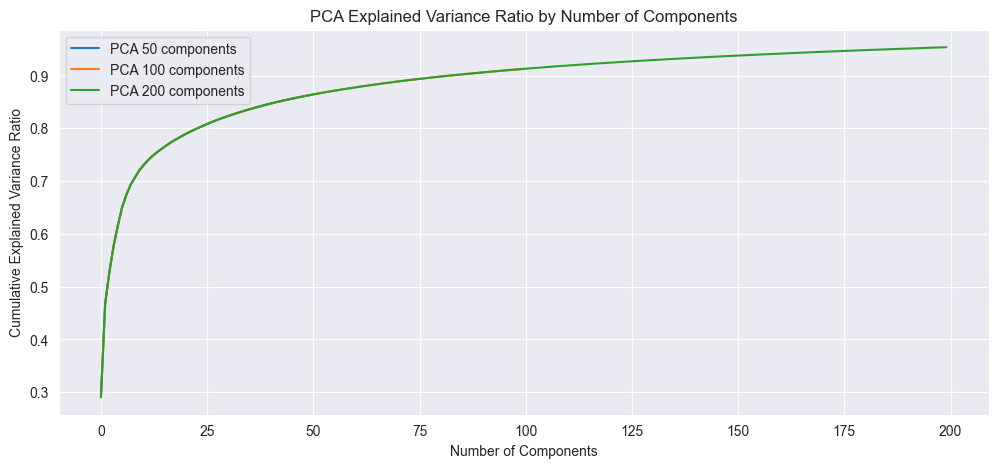

In [27]:
# 1. Apply PCA
def apply_pca(X_train, X_test, n_components):
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    # Calculate explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
    
    return X_train_pca, X_test_pca, explained_variance_ratio, cumulative_variance_ratio

# Apply PCA with different component counts
n_components_list = [50, 100, 200]
pca_results = {}

for n in n_components_list:
    X_train_pca, X_test_pca, var_ratio, cum_var_ratio = apply_pca(X_train, X_test, n)
    pca_results[n] = {
        'X_train': X_train_pca,
        'X_test': X_test_pca,
        'var_ratio': var_ratio,
        'cum_var_ratio': cum_var_ratio
    }
    
    # Print explained variance ratio for each PCA component count
    print(f"PCA with {n} components:")
    print(f"Explained Variance Ratio (first 10 components): {var_ratio[:10]}")
    print(f"Cumulative Explained Variance Ratio: {cum_var_ratio[-1]:.4f}")
    print("")

# 3. Visualize cumulative explained variance ratio for each PCA component count
plt.figure(figsize=(12, 5))
for n in n_components_list:
    plt.plot(pca_results[n]['cum_var_ratio'], label=f'PCA {n} components')

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA Explained Variance Ratio by Number of Components')
plt.legend()
plt.grid(True)
plt.show()


Dữ liệu có đến 28x28 chiều nhưng chỉ cần 50 vector thành phần đã có thể giải thích được đến 86,26% của bộ dữ liệu, nếu 200 thành phần thì lên đến 95% bộ dữ liệu

In [28]:
from sklearn.decomposition import PCA

# Định nghĩa hàm reconstruction
def reconstruction(x, n_components, pca):
    """
    Tái tạo một hình ảnh từ một vector PCA với số lượng thành phần `n_components`.
    """
    # Chọn n_components đầu tiên của PCA cho việc tái tạo
    x_reduced = pca.transform([x])[0][:n_components]
    # Đặt các thành phần còn lại bằng 0
    x_full = np.zeros(pca.n_components_)
    x_full[:n_components] = x_reduced
    # Inverse transform để tái tạo lại hình ảnh gốc
    return pca.inverse_transform([x_full])[0]


def n_sample_reconstructions(X, n_samples=5, trans_n=200, trans=None):
    sample_indices = np.round(np.random.random(n_samples) * len(X)).astype(int)
    return (sample_indices, 
            np.vstack([reconstruction(X[ind], trans_n, trans) for ind in sample_indices]))

def plot_reconstructions(X, n_samples=5, trans_list=[50, 120, 200], trans=None):
    """
    Plots `n_samples` reconstructions for each specified number of components in `trans_list`.
    """
    fig, axarr = plt.subplots(n_samples, 4, figsize=(8, n_samples * 2))
    
    for i in range(n_samples):
        index = int(np.random.randint(0, len(X)))
        
        # Vẽ hình ảnh gốc
        sns.heatmap(X[index].reshape(28, 28), cmap='gray_r', ax=axarr[i][0])
        axarr[i][0].set_title("Original Image", fontsize=12)
        axarr[i][0].axis('off')
        
        # Vẽ các ảnh tái tạo từ số lượng thành phần PCA khác nhau
        for j, n_components in enumerate(trans_list):
            recon_img = reconstruction(X[index], n_components, trans).reshape(28, 28)
            sns.heatmap(recon_img, cmap='gray_r', ax=axarr[i][j + 1])
            axarr[i][j + 1].set_title(f"{n_components}-Vector Rec", fontsize=12)
            axarr[i][j + 1].axis('off')
    
    plt.tight_layout()
    plt.show()


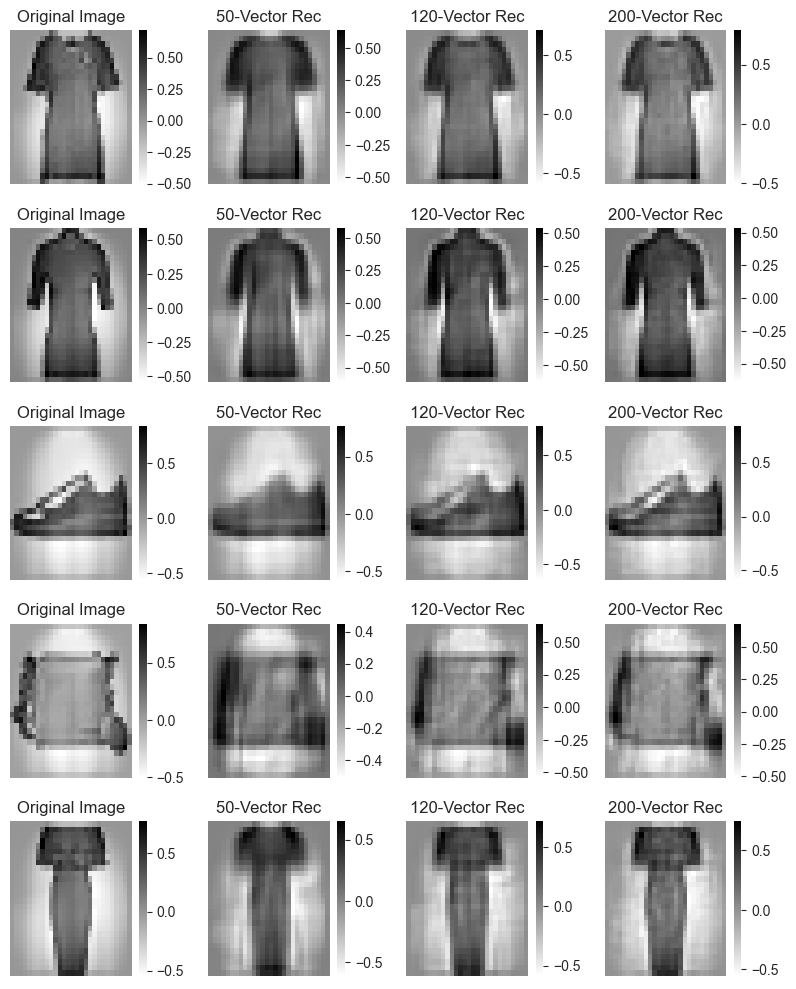

In [29]:
# Thực hiện PCA với số lượng thành phần tối đa cần thiết
max_components = 200
pca = PCA(n_components=max_components)
X_pca = pca.fit_transform(X_test)  # Biến đổi dữ liệu bằng PCA

# Gọi hàm plot_reconstructions với các số lượng thành phần PCA khác nhau
plot_reconstructions(X_test, n_samples=5, trans_list=[50, 120, 200], trans=pca)

In [30]:
# 2. Thực hiện LDA
def apply_lda(X_train, X_test, y_train, y_test, n_components):
    lda = LDA(n_components=n_components)
    X_train_lda = lda.fit_transform(X_train, y_train)
    X_test_lda = lda.transform(X_test)
    return X_train_lda, X_test_lda

# LDA chỉ có thể giảm xuống số classes - 1
X_train_lda, X_test_lda = apply_lda(X_train, X_test, y_train, y_test, n_components=9)

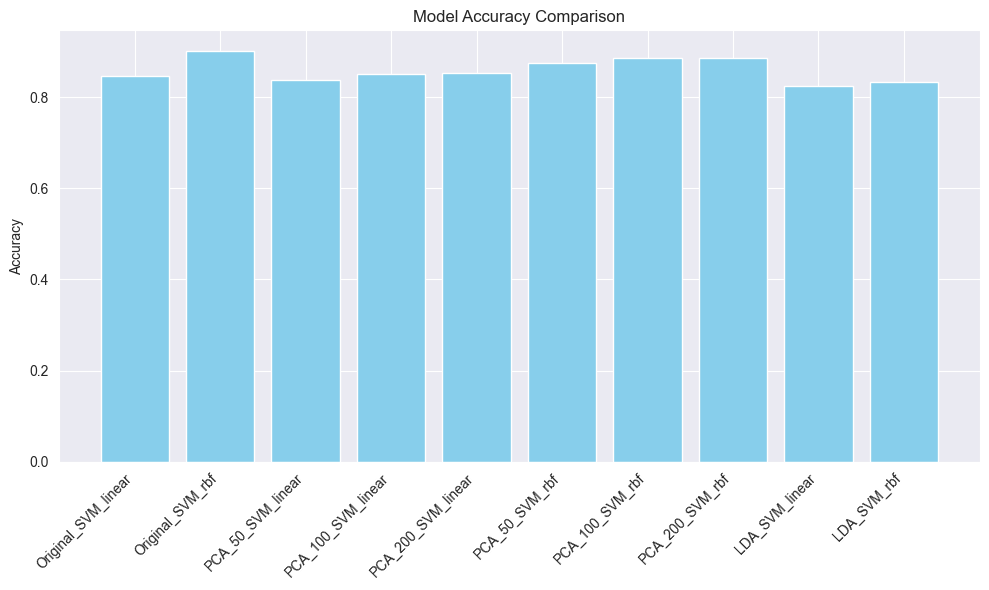

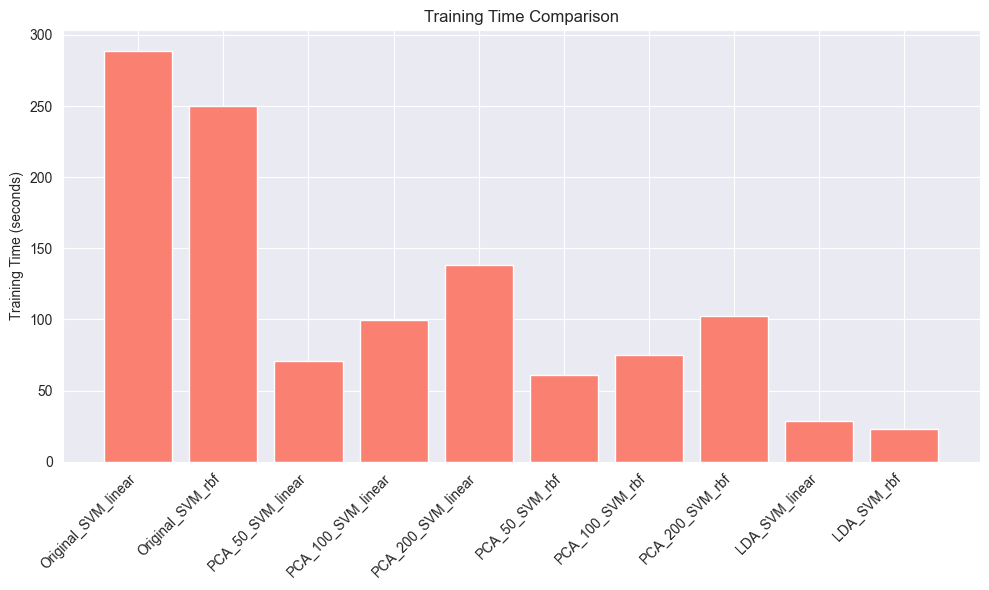


Detailed Results Table:


,Model,Accuracy,Train Time (s),Predict Time (s)
0,Original_SVM_linear,0.8464,288.805214,59.510849
1,Original_SVM_rbf,0.9013,250.244291,100.893917
2,PCA_50_SVM_linear,0.8365,70.899405,6.369592
3,PCA_100_SVM_linear,0.8495,99.475996,10.038853
4,PCA_200_SVM_linear,0.8521,138.219895,16.786967
5,PCA_50_SVM_rbf,0.8750,61.048853,20.730717
6,PCA_100_SVM_rbf,0.8847,75.047706,24.140675
7,PCA_200_SVM_rbf,0.8855,102.164154,31.683364
8,LDA_SVM_linear,0.8253,28.770586,3.479590
9,LDA_SVM_rbf,0.8341,23.263904,14.727876


In [31]:
# 4. Train và evaluate models (simplified without classification_report)
def train_and_evaluate(X_train, X_test, y_train, y_test, kernel='rbf'):
    model = SVC(kernel=kernel)
    
    # Training time
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # Prediction time
    start_time = time.time()
    y_pred = model.predict(X_test)
    predict_time = time.time() - start_time
    
    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    return {
        'accuracy': accuracy,
        'train_time': train_time,
        'predict_time': predict_time,
    }

# Dictionary để lưu kết quả
results = {
    'Original_SVM_linear': {
        'accuracy': linear_acc,
        'train_time': linear_train_time,
        'predict_time': linear_pred_time,
    },
    'Original_SVM_rbf': {
        'accuracy': rbf_acc,
        'train_time': rbf_train_time,
        'predict_time': rbf_pred_time,
    }
}

# Train trên dữ liệu PCA cho SVM Linear và RBF
for kernel in ['linear', 'rbf']:
    for n in n_components_list:
        results[f'PCA_{n}_SVM_{kernel}'] = train_and_evaluate(
            pca_results[n]['X_train'], pca_results[n]['X_test'], y_train, y_test, kernel
        )

# Train trên dữ liệu LDA
for kernel in ['linear', 'rbf']:
    results[f'LDA_SVM_{kernel}'] = train_and_evaluate(
        X_train_lda, X_test_lda, y_train, y_test, kernel
    )

# 5. Visualize results with separate plots
def plot_comparison(results):
    # Extract data for plotting
    methods = list(results.keys())
    accuracies = [results[m]['accuracy'] for m in methods]
    train_times = [results[m]['train_time'] for m in methods]
    
    # Plot accuracy comparison
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(methods)), accuracies, color='skyblue')
    plt.xticks(range(len(methods)), methods, rotation=45, ha='right')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy Comparison')
    plt.tight_layout()
    plt.show()

    # Plot training time comparison
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(methods)), train_times, color='salmon')
    plt.xticks(range(len(methods)), methods, rotation=45, ha='right')
    plt.ylabel('Training Time (seconds)')
    plt.title('Training Time Comparison')
    plt.tight_layout()
    plt.show()

plot_comparison(results)

# 6. Display detailed results in a table
def display_results_table(results):
    # Convert results dictionary to DataFrame
    df_results = pd.DataFrame({
        'Model': list(results.keys()),
        'Accuracy': [results[m]['accuracy'] for m in results],
        'Train Time (s)': [results[m]['train_time'] for m in results],
        'Predict Time (s)': [results[m]['predict_time'] for m in results]
    })
    
    # Display the DataFrame as a table
    print("\nDetailed Results Table:")
    display(df_results)

display_results_table(results)


Nhìn vào bảng kết quả chi tiết của các mô hình SVM với các cấu hình khác nhau, ta có thể phân tích về thời gian huấn luyện và độ chính xác như sau:

1. Original SVM Linear vs. Original SVM RBF:
- Độ chính xác: Mô hình SVM với kernel RBF có độ chính xác cao hơn đáng kể (0.9013) so với kernel tuyến tính (0.8464). Điều này có thể là do kernel RBF có khả năng biểu diễn các biên quyết định phi tuyến tính, giúp nó phù hợp hơn với dữ liệu có cấu trúc phức tạp.
Thời gian huấn luyện: Mô hình RBF yêu cầu nhiều thời gian huấn luyện hơn (274.63 giây so với 340.94 giây cho kernel tuyến tính), điều này có thể được giải thích bởi sự phức tạp của RBF kernel, yêu cầu tính toán khoảng cách phi tuyến giữa các điểm dữ liệu.
SVM Linear với các thành phần PCA khác nhau (50, 100, 200):

- Độ chính xác: Khi số lượng thành phần PCA tăng (từ 50 đến 200), độ chính xác tăng nhẹ từ 0.8365 lên 0.8516. Điều này cho thấy rằng việc giữ lại nhiều thông tin hơn về dữ liệu qua PCA giúp mô hình phân loại tốt hơn.
- Thời gian huấn luyện: Thời gian huấn luyện của SVM giảm rõ rệt khi áp dụng PCA, đặc biệt là với PCA 50 thành phần (98.69 giây) so với mô hình gốc (340.93 giây). Điều này là do số chiều dữ liệu giảm, giúp SVM tính toán hiệu quả hơn.
SVM RBF với các thành phần PCA khác nhau (50, 100, 200):

Độ chính xác: SVM RBF đạt độ chính xác cao hơn đáng kể so với SVM tuyến tính khi áp dụng PCA, với PCA 200 thành phần đạt độ chính xác cao nhất là 0.8856. Điều này cho thấy rằng RBF kernel kết hợp với PCA có thể nắm bắt các đặc điểm phức tạp hơn của dữ liệu.
Thời gian huấn luyện: Thời gian huấn luyện giảm đáng kể khi áp dụng PCA, ví dụ với PCA 50 thành phần là 48.47 giây, nhanh hơn so với mô hình SVM RBF gốc (274.63 giây).
LDA với SVM Linear và RBF:

Độ chính xác: Các mô hình SVM với LDA có độ chính xác thấp hơn (0.8253 với linear và 0.8341 với RBF) so với các mô hình SVM PCA hoặc không sử dụng giảm chiều. Điều này có thể là do LDA tối ưu hóa cho việc phân tách các lớp nhưng không giữ lại nhiều thông tin biến thiên như PCA.
Thời gian huấn luyện: Cả hai mô hình LDA-SVM đều có thời gian huấn luyện rất ngắn (32.14 giây cho tuyến tính và 22.76 giây cho RBF). Điều này là do LDA giảm chiều dữ liệu rất mạnh, giới hạn số lượng thành phần tối đa (c - 1, với c là số lớp).
Kết luận:
Về độ chính xác: SVM với kernel RBF và PCA đạt được độ chính xác cao nhất, đặc biệt khi sử dụng nhiều thành phần PCA (100 hoặc 200).
Về thời gian huấn luyện: PCA giúp giảm đáng kể thời gian huấn luyện cho cả kernel tuyến tính và RBF. LDA cho thời gian huấn luyện ngắn nhất nhưng đánh đổi bằng độ chính xác thấp hơn.
Lý do cho các xu hướng này chủ yếu là do tính chất của kernel và cách giảm chiều dữ liệu. Kernel RBF phù hợp với dữ liệu phi tuyến, trong khi LDA làm mất thông tin về biến thiên tổng thể khi cố gắng tối ưu hóa cho việc phân lớp.

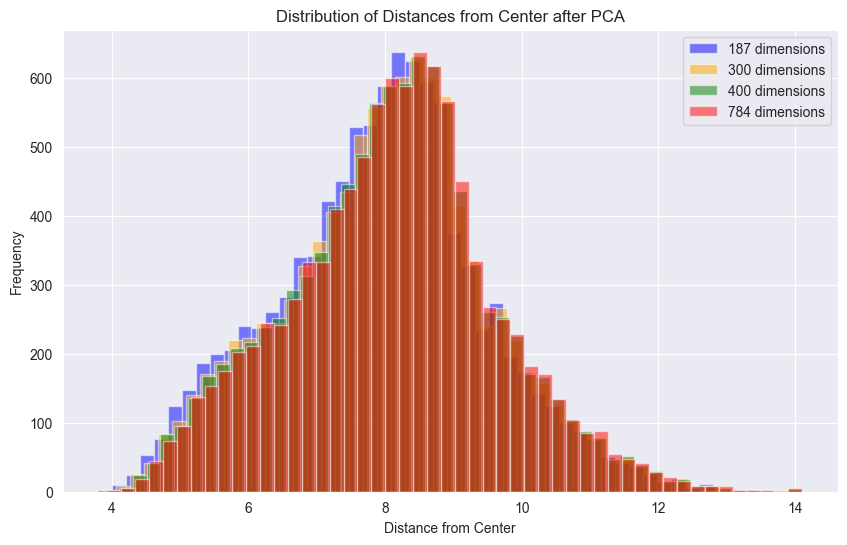

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml

# Load dữ liệu Fashion MNIST
sample_size = 10000
X_sample = X_train[:sample_size]  # Chọn 10,000 mẫu đầu tiên

# Các số chiều sau PCA cần kiểm tra
dimensions = [187, 300, 400, 784]
colors = ['blue', 'orange', 'green', 'red']

plt.figure(figsize=(10, 6))

# Tạo histogram cho mỗi số chiều sau khi áp dụng PCA
for dim, color in zip(dimensions, colors):
    # Áp dụng PCA
    pca = PCA(n_components=dim)
    X_reduced = pca.fit_transform(X_sample)
    
    # Tính khoảng cách từ mỗi điểm đến tâm
    center = np.mean(X_reduced, axis=0)
    distances = np.linalg.norm(X_reduced - center, axis=1)
    
    # Vẽ histogram
    plt.hist(distances, bins=50, color=color, alpha=0.5, label=f'{dim} dimensions')

plt.title('Distribution of Distances from Center after PCA')
plt.xlabel('Distance from Center')
plt.ylabel('Frequency')
plt.legend()
plt.show()


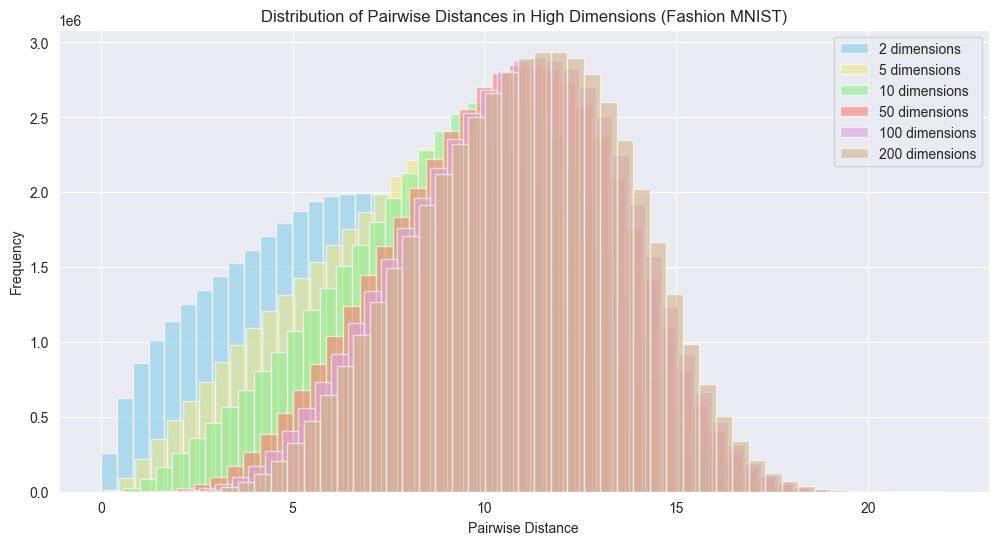

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist
from sklearn.datasets import fetch_openml

# Tải dữ liệu Fashion MNIST
X_sample2 = X_train[:10000]  # Chọn 1000 mẫu đầu tiên để giảm tính toán

# Các số chiều cần kiểm tra sau khi giảm chiều bằng PCA
dimensions = [2, 5, 10, 50, 100, 200]
colors = ['skyblue', 'khaki', 'lightgreen', 'salmon', 'plum', 'tan']

plt.figure(figsize=(12, 6))

# Tạo và vẽ histogram cho mỗi số chiều sau khi áp dụng PCA
for dim, color in zip(dimensions, colors):
    # Áp dụng PCA để giảm chiều dữ liệu xuống số chiều `dim` dec
    pca = PCA(n_components=dim)
    X_reduced = pca.fit_transform(X_sample2)
    
    # Tính khoảng cách từng cặp giữa các điểm trong không gian giảm chiều
    distances = pdist(X_reduced)
    
    # Vẽ histogram cho phân phối khoảng cách
    plt.hist(distances, bins=50, color=color, alpha=0.6, label=f'{dim} dimensions')

plt.title('Distribution of Pairwise Distances in High Dimensions (Fashion MNIST)')
plt.xlabel('Pairwise Distance')
plt.ylabel('Frequency')
plt.legend()
plt.show()


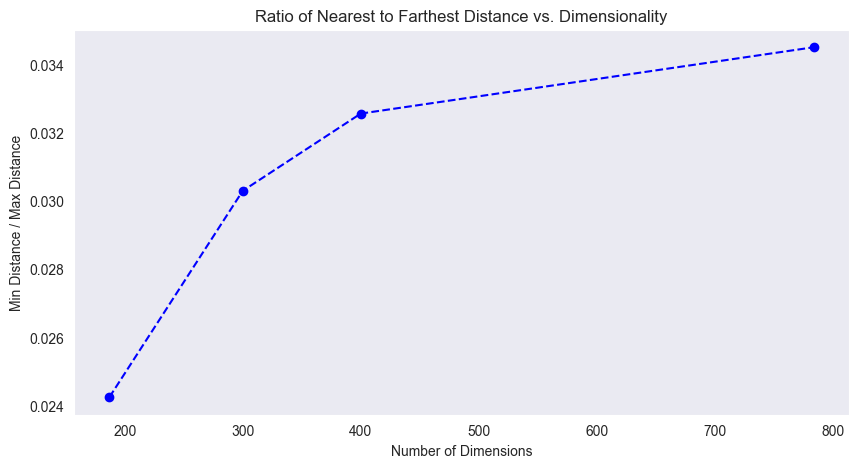

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist
from sklearn.datasets import fetch_openml

# Tải dữ liệu Fashion MNIST
X_sample3 = X_train[:10000]  # Chọn 1000 mẫu đầu tiên để giảm tính toán

# Các số chiều cần kiểm tra sau khi giảm chiều bằng PCA
dimensions = [187, 300, 400, 784]
ratios = []

# Tính tỷ lệ khoảng cách nhỏ nhất/lớn nhất cho mỗi số chiều
for dim in dimensions:
    # Áp dụng PCA để giảm chiều dữ liệu xuống số chiều `dim`
    pca = PCA(n_components=dim)
    X_reduced = pca.fit_transform(X_sample3)
    
    # Tính khoảng cách từng cặp giữa các điểm trong không gian giảm chiều
    distances = pdist(X_reduced)
    
    # Tính khoảng cách nhỏ nhất và lớn nhất
    min_distance = np.min(distances)
    max_distance = np.max(distances)
    
    # Tính tỷ lệ và thêm vào danh sách `ratios`
    ratio = min_distance / max_distance
    ratios.append(ratio)

# Vẽ biểu đồ
plt.figure(figsize=(10, 5))
plt.plot(dimensions, ratios, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Dimensions')
plt.ylabel('Min Distance / Max Distance')
plt.title('Ratio of Nearest to Farthest Distance vs. Dimensionality')
plt.grid()
plt.show()


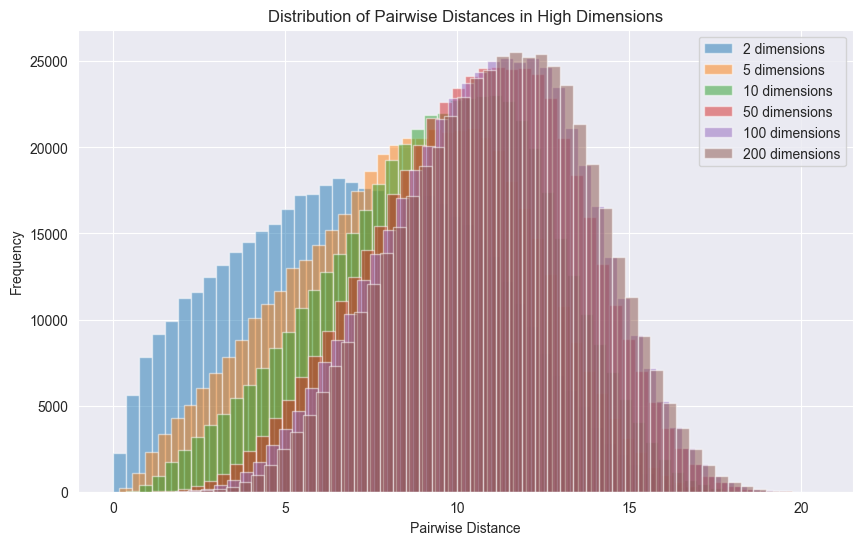

In [46]:
from scipy.spatial.distance import pdist
import numpy as np
import matplotlib.pyplot as plt

# Tải dữ liệu Fashion MNIST
X_sample4 = X_train[:1000]  # Chọn 1000 mẫu đầu tiên để giảm tính toán

# Plot the distribution of pairwise distances for different dimensions
plt.figure(figsize=(10, 6))
for dim, color in zip(dimensions, colors):
    pca = PCA(n_components=dim)
    X_reduced = pca.fit_transform(X_sample4)
    distances = pdist(X_reduced,metric='euclidean')
    plt.hist(distances, bins=50, alpha=0.5, label=f'{dim} dimensions')

plt.title('Distribution of Pairwise Distances in High Dimensions')
plt.xlabel('Pairwise Distance')
plt.ylabel('Frequency')
plt.legend()
plt.show()

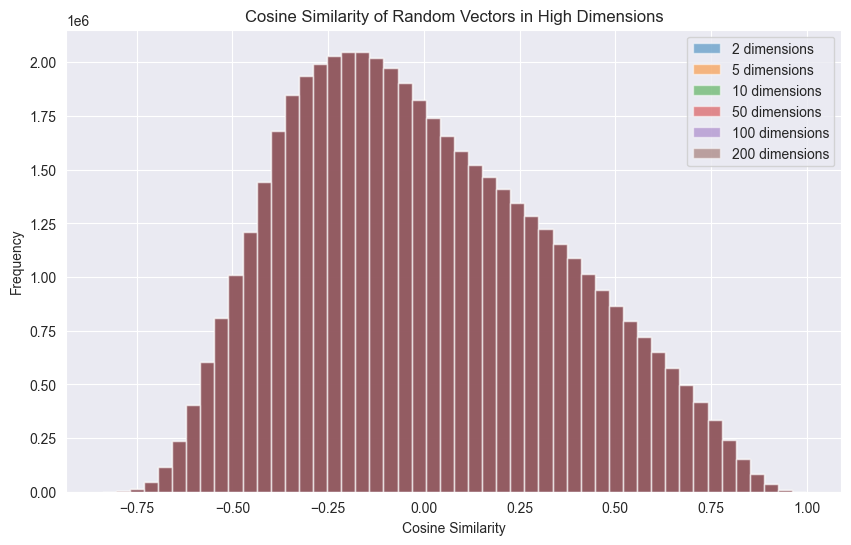

In [50]:
# Tải dữ liệu Fashion MNIST
X_sample5 = X_train[:10000]  # Chọn 1000 mẫu đầu tiên để giảm tính toán

def cosine_similarity(vectors):
    from sklearn.metrics.pairwise import cosine_similarity
    return cosine_similarity(vectors)

# Parameters
dimensions_list = [2, 5, 10, 50, 100, 200]

# Plot the distribution of cosine similarities for different dimensions
plt.figure(figsize=(10, 6))
for dim in dimensions_list:
    cos_sim = cosine_similarity(X_sample5)
    # Only keep the upper triangular part of the similarity matrix (since it's symmetric)
    cos_sim_upper = cos_sim[np.triu_indices_from(cos_sim, k=1)]
    plt.hist(cos_sim_upper, bins=50, alpha=0.5, label=f'{dim} dimensions')

plt.title('Cosine Similarity of Random Vectors in High Dimensions')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [2]:
import ollama


In [3]:
response = ollama.chat(model='llama3.2', messages=[
  {
    'role': 'user',
    'content': 'Why is the sky blue?',
  },
])
print(response['message']['content'])

The sky appears blue because of a phenomenon called Rayleigh scattering, named after the British physicist Lord Rayleigh, who first described it in the late 19th century.

Here's what happens:

1. Sunlight enters Earth's atmosphere and is made up of a spectrum of colors, including all the colors of the visible light spectrum.
2. When sunlight encounters tiny molecules of gases such as nitrogen (N2) and oxygen (O2), which are present in the air, it scatters in all directions.
3. The smaller molecules are more effective at scattering shorter (blue) wavelengths than longer (red) wavelengths.
4. As a result, when we look up at the sky, our eyes see more blue light scattered by these tiny molecules than any other color.

This is why the sky appears blue during the daytime, especially in the direction of the sun. The amount of scattering that occurs depends on the angle of the sunlight and the position of the observer.

It's worth noting that the color of the sky can change under different c